# Sentiment Analysis  (in progress)

Sentiment classification system using traditional machine learning and modern Recurrent Neural Network approaches

Dataset: [Stanford's Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/). Movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either 'positive', if the reviewer enjoyed the film, or 'negative' otherwise.

Structure of the data: 
- train/
     - pos/
     - neg/
- test/
     - pos/
     - neg/
     
Based on [Sentiment Analysis exercise](https://github.com/udacity/AIND-NLP/blob/master/sentiment_analysis.ipynb) of the [Udacity's Artificial Intelligence Nanodegree](https://www.udacity.com/course/artificial-intelligence-nanodegree--nd889)


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the data

In [2]:
import os
import glob
import zipfile


def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory """

    if not os.path.isdir(data_dir):
        print("Extracting data ...")
        with zipfile.ZipFile("data/imdb-reviews.zip","r") as zip_ref:
            zip_ref.extractall('data')
    
    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [3]:
print(data['train']['pos'][2])

This film and it's sequel Barry Mckenzie holds his own, are the two greatest comedies to ever be produced. A great story a young Aussie bloke travels to england to claim his inheritance and meets up with his mates, who are just as loveable and innocent as he is.<br /><br />It's chock a block full of great, sayings , where else could you find someone who needs a drink so bad that he's as dry as a dead dingoes donger? great characters, top acting, and it's got great sheilas and more Fosters consumption then any other three films put together. Top notch.<br /><br />And some of the funniest songs you'll ever hear, and it's full of great celebrities. Definitely my two favourite films of all time, I watch them at least once a fortnight.


### Wordcloud visualization

Positive reviews:


(-0.5, 799.5, 399.5, -0.5)

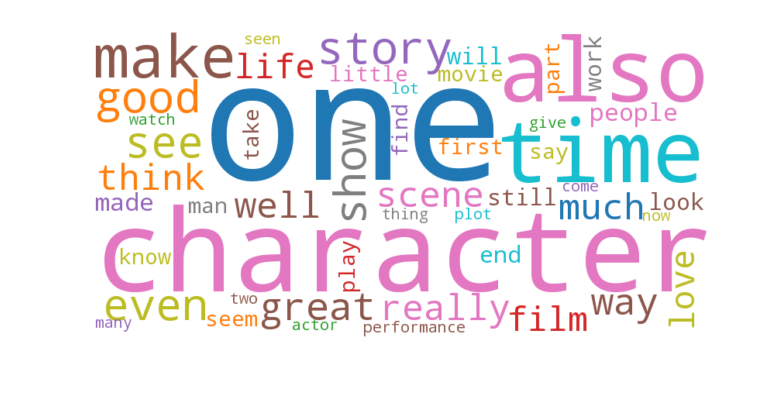

In [4]:
from wordcloud import WordCloud, STOPWORDS

# Combine all reviews for the desired sentiment
pos_text = " ".join([review for review in data['train']['pos']])

# update stopwords to include common words like film and movie
stopwords = STOPWORDS.update(['br','film','movie'])

# Generate and plot wordcloud
wc = WordCloud(background_color='white', max_words=50, width=400, height=200, scale=2,
        colormap="tab10")       
plt.figure(figsize=(4, 3), dpi=200)
print("Positive reviews:")
plt.imshow(wc.generate(pos_text), interpolation='bilinear')
plt.axis('off')

## Split into training and test sets


In [5]:
from sklearn.utils import shuffle

# Combine positive and negative reviews and labels
data_train = data['train']['pos'] + data['train']['neg']
data_test = data['test']['pos'] + data['test']['neg']    
labels_train = labels['train']['pos'] + labels['train']['neg']
labels_test = labels['test']['pos'] + labels['test']['neg']    

# Shuffle reviews and corresponding labels within training and test sets
data_train, labels_train = shuffle(data_train, labels_train, random_state=9)
data_test, labels_test = shuffle(data_test, labels_test, random_state=9)

print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Preprocess the data

In [8]:
from bs4 import BeautifulSoup 
import re
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer

def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    review = BeautifulSoup(review, "html5lib").get_text()  # remove HTML tags
    review = re.sub(r"[^a-zA-Z0-9]", " ", review)  # remove non-letters
    review = review.lower()  # convert to lowercase
    words = review.split()  # tokenize
    words = [w for w in words if w not in stopwords.words("english")]  # remove stopwords    
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]  # stem

    
    # Return final list of words
    return words

review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

[nltk_data] Downloading package stopwords to /home/angel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['test', 'test', 'would', 'make', 'great', 'movi', 'review']

In [9]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
Bill and Ted's bogus journey is possible the most excellent film I have ever watched. Though the acting and scenery etc is poor, who cares. The story line is brilliant and the jokes and words they come up with are most excellent, the ideas are great as well. I recommend anyone to see this classic. The best part is obviously when they 'melvin' death, i was cracking up for 10 minutes and missed the next part of the film. This is so much better then the first one, which was great as well. Possibly the funniest movie of all time!!!!! I think the best parts of the film however, are when Bill and Ted shout excellent and play the guitar solo, it was hilarious. Rock on Bill, Ted and Eddie Van Halen, bring out a 3rd film!!

--- Preprocessed words ---
['first', 'like', 'much', 'central', 'idea', 'locat', 'intrud', 'other', 'fragil', 'self', 'variou', 'level', 'mainli', 'subconsci', 'sometim', 'allegor', 'fact', 'in

## Extract Bag-of-Words features

> **Note**: The set of words in the training set may not be exactly the same as the test set. What do you do if you encounter a word during testing that you haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

Implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

> **Hint**: You may find it useful to take advantage of `CountVectorizer` from scikit-learn. Also make sure to pickle your Bag-of-Words transformation so that you can use it in future.

In [26]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        
        vectorizer = CountVectorizer(decode_error='ignore', max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.fit_transform(words_test).toarray()
        
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary
    
words_train, words_test = data_train, data_test   

# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Wrote features to cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['stark', 'nights', 'here', 'positive', 'suspenseful', 'millions', 'punk', 'game']

--- Preprocessed words ---
['film', 'sir', 'christoph', 'strong', 'mp', 'member', 'parliament', 'play', 'colin', 'clive', 'affair', 'amelia', 'earhart', 'like', 'charact', 'play', 'katherin', 'hepburn', 'met', 'devot', 'husband', 'met', 'odd', 'fascin', 'hepburn', 'help', 'fell', 'love', 'tell', 'stare', 'space', 'lot', 'talk', 'endlessli', 'pain', 'unrequit', 'love', 'frankli', 'terribl', 'date', 'practic', 'imposs', 'film', 'watch', 'part', 'problem', 'pre', 'code', 'day', 'film', 'glamor', 'adulteri', 'common', 'plu', 'even', 'accept', 'moral', 'suspect', 'subject', 'utter', 'sappi', 'dialog', 'make', 'sound', 'like', '19th', 'centuri', 'romanc', 'novel', 'realli', 'bad', 'one', 'sticki', 'difficult', 'like', 'charact', 'clive', 'wife', 'nice', 'ladi', 'one', 'harm', 'make', 'one', 'big', 'wast', 'time', 'interest', '

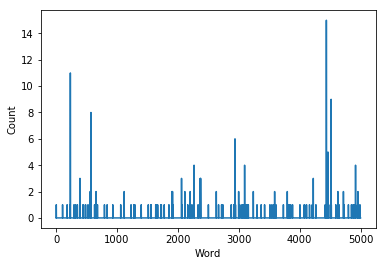

In [27]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

#### Question:  
What is the average sparsity level of BoW vectors in our training set? In other words, on average what percentage of entries in a BoW feature vector are zero?

### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

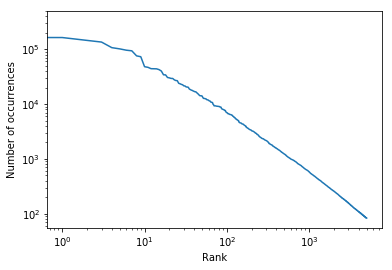

In [28]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

#### Question: Zipf's law

What is the total number of occurrences of the most frequent word? What is the the total number of occurrences of the second most frequent word? Do your numbers follow  Zipf's law? If not, why?


### Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [35]:
import sklearn.preprocessing as pr

# Normalize BoW features in training and test set
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

MemoryError: 

## Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [36]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB().fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

MemoryError: 

Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. As your next task, you will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### TODO: Gradient-Boosted Decision Tree classifier

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. We use default parameters for some of them and pre-set the rest for you, except one: `n_estimators`. Find a proper value for this hyperparameter, use it to classify the data, and report how much improvement you get over Naive Bayes in terms of accuracy.

> **Tip**: Use a model selection technique such as cross-validation, grid-search, or an information criterion method, to find an optimal value for the hyperparameter.

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 100

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # Classify the data using GradientBoostingClassifier
    clf.fit(X_train, X_test)
      
    # Print final training & test accuracy
    pred_train = clf.predict(features_train)
    pred_test = clf.predict(features_test)
    acc_train = accuracy_score(pred, labels_train)
    acc_test = accuracy_score(pred, labels_test)
    
    print("training accuracy: \t\t {:.6f}".format(acc_train))
    print("test accuracy: \t\t {:.6f}".format(acc_test))
    print("test time(s): \t {:.6f}".format(t2 - t2))
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

ValueError: bad input shape (25000, 5000)

### TODO: Adverserial testing

Write a short movie review to trick your machine learning model! That is, a movie review with a clear positive or negative sentiment that your model will classify incorrectly.

> **Hint**: You might want to take advantage of the biggest weakness of the Bag-of-Words scheme!

In [ ]:
# TODO: Write a sample review and set its true sentiment
my_review = "The writer and director did well on his first movie, but this one is an absolute nonsense. \
I like complicated, non-linear and abstract movies, the more I learn from the them the better. \
The photography is good, although nothing can be learn from this lame script, 
true_sentiment = 'neg' 

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data

# TODO: Then call your classifier to label it


## Modern Approach: RNNs
Keras has a built-in [IMDb movie reviews dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification) that we can use, with the same vocabulary size.

In [ ]:
from keras.datasets import imdb  # import the built-in imdb dataset in Keras

# Set the vocabulary size
vocabulary_size = 5000

# Load in training and test data (note the difference in convention compared to scikit-learn)
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print("Loaded dataset with {} training samples, {} test samples".format(len(X_train), len(X_test)))

In [ ]:
# Inspect a sample review and its label
print("--- Review ---")
print(X_train[7])
print("--- Label ---")
print(y_train[7])

Notice that the label is an integer (0 for negative, 1 for positive), and the review itself is stored as a sequence of integers. These are word IDs that have been preassigned to individual words. To map them back to the original words, you can use the dictionary returned by `imdb.get_word_index()`.

In [ ]:
# Map word IDs back to words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print("--- Review (with words) ---")
print([id2word.get(i, " ") for i in X_train[7]])
print("--- Label ---")
print(y_train[7])

Unlike our Bag-of-Words approach, where we simply summarized the counts of each word in a document, this representation essentially retains the entire sequence of words (minus punctuation, stopwords, etc.). This is critical for RNNs to function. But it also means that now the features can be of different lengths!

#### Question: 

What is the maximum review length (in terms of number of words) in the training set? What is the minimum?


### Pad sequences

Set `max_words` to 500.

In [ ]:
from keras.preprocessing import sequence

# Set the maximum number of words per document (for both training and testing)
max_words = 500

# TODO: Pad sequences in X_train and X_test

### RNN Model

Remember that your input is a sequence of words (technically, integer word IDs) of maximum length = `max_words`, and your output is a binary sentiment label (0 or 1).

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# TODO: Design your model
model = ?

print(model.summary())

### Train and evaluate the model

In [ ]:
# TODO: Compile your model, specifying a loss function, optimizer, and metrics


Once compiled, you can kick off the training process. There are two important training parameters that you have to specify - **batch size** and **number of training epochs**, which together with your model architecture determine the total training time.

Training may take a while, so grab a cup of coffee, or better, go for a hike! If possible, consider using a GPU, as a single training run can take several hours on a CPU.

> `validation_split` - a fraction of the training data for Keras to set aside for this purpose (typically 5-10%). Validation metrics are evaluated once at the end of each epoch.

In [ ]:
# TODO: Specify training parameters: batch size and number of epochs
batch_size = ?
num_epochs = ?

# TODO(optional): Reserve/specify some training data for validation (not to be used for training)

# TODO: Train your model


In [ ]:
# Save your model, so that you can quickly load it in future (and perhaps resume training)
model_file = "rnn_model.h5"  # HDF5 file
model.save(os.path.join(cache_dir, model_file))

# Later you can load it using keras.models.load_model()
#from keras.models import load_model
#model = load_model(os.path.join(cache_dir, model_file))

Once you have trained your model, it's time to see how well it performs on unseen test data.

In [ ]:
# Evaluate your model on the test set
scores = model.evaluate(X_test, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

#### Question: Comparing RNNs and Traditional Methods

How well does your RNN model perform compared to the BoW + Gradient-Boosted Decision Trees?



## Extensions

There are several ways in which you can build upon this notebook. Each comes with its set of challenges, but can be a rewarding experience.

- The first thing is to try and improve the accuracy of your model by experimenting with different architectures, layers and parameters. How good can you get without taking prohibitively long to train? How do you prevent overfitting?

- Then, you may want to deploy your model as a mobile app or web service. What do you need to do in order to package your model for such deployment? How would you accept a new review, convert it into a form suitable for your model, and perform the actual prediction? (Note that the same environment you used during training may not be available.)

- One simplification we made in this notebook is to limit the task to binary classification. The dataset actually includes a more fine-grained review rating that is indicated in each review's filename (which is of the form `<[id]_[rating].txt>` where `[id]` is a unique identifier and `[rating]` is on a scale of 1-10; note that neutral reviews > 4 or < 7 have been excluded). How would you modify the notebook to perform regression on the review ratings? In what situations is regression more useful than classification, and vice-versa?

Whatever direction you take, make sure to share your results and learnings with your peers, through blogs, discussions and participating in online competitions. This is also a great way to become more visible to potential employers!